<a href="https://colab.research.google.com/github/SeanMuInCa/learn_python/blob/master/fakenews_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [380]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [381]:
import pandas as pd
import numpy as np

In [382]:
import re

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py

In [383]:

train = pd.read_csv('train1.csv')
test = pd.read_csv('test1.csv')
valid = pd.read_csv('valid1.csv')

In [384]:
train.head()

,ID,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context
0,2635.json,FALSE,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,FALSE,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [385]:
test.head()

,ID,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context
0,11972.json,TRUE,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,FALSE,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,FALSE,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


In [386]:
valid.head()

,ID,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context
0,12134.json,barely-true,We have less Americans working now than in the...,"economy,jobs",vicky-hartzler,U.S. Representative,Missouri,republican,1,0,1,0,0,an interview with ABC17 News
1,238.json,pants-fire,"When Obama was sworn into office, he DID NOT u...","obama-birth-certificate,religion",chain-email,NaN,NaN,none,11,43,8,5,105,NaN
2,7891.json,FALSE,Says Having organizations parading as being so...,"campaign-finance,congress,taxes",earl-blumenauer,U.S. representative,Oregon,democrat,0,1,1,1,0,a U.S. Ways and Means hearing
3,8169.json,half-true,Says nearly half of Oregons children are poor.,poverty,jim-francesconi,Member of the State Board of Higher Education,Oregon,none,0,1,1,1,0,an opinion article
4,929.json,half-true,On attacks by Republicans that various program...,"economy,stimulus",barack-obama,President,Illinois,democrat,70,71,160,163,9,interview with CBS News


In [387]:
train.shape, test.shape, valid.shape

((10240, 14), (1267, 14), (1284, 14))

In [388]:
data = pd.concat([train, test, valid])

In [389]:
df = data.drop(columns=['ID'])
df

,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context
0,FALSE,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,FALSE,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279,half-true,"For the first time in more than a decade, impo...","energy,oil-spill,trade",barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,a press conference
1280,mostly-true,Says Donald Trump has bankrupted his companies...,candidates-biography,hillary-clinton,Presidential candidate,New York,democrat,40.0,29.0,69.0,76.0,7.0,a speech on the economy
1281,TRUE,"John McCain and George Bush have ""absolutely n...",health-care,campaign-defend-america,NaN,"Washington, D.C.",none,0.0,1.0,0.0,2.0,0.0,a television ad
1282,FALSE,A new poll shows 62 percent support the presid...,health-care,americans-united-change,NaN,NaN,none,1.0,4.0,4.0,1.0,0.0,an Internet ad.


In [390]:
df.isnull().sum()

,0
label,0
statement,0
subject(s),2
speaker,2
speaker's job title,3568
state info,2751
party affiliation,2
barely true counts,2
false counts,2
half true counts,2


In [391]:
df.isnull().sum().sum()

np.int64(6466)

In [392]:
df = df.dropna()
df.isnull().sum()

,0
label,0
statement,0
subject(s),0
speaker,0
speaker's job title,0
state info,0
party affiliation,0
barely true counts,0
false counts,0
half true counts,0


In [393]:
df.head(20)

,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,context
0,FALSE,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
5,TRUE,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece
7,half-true,I'm the only person on this stage who has work...,ethics,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,"a Democratic debate in Philadelphia, Pa."
9,mostly-true,Says GOP primary opponents Glenn Grothman and ...,"energy,message-machine-2014,voting-record",duey-stroebel,State representative,Wisconsin,republican,0.0,0.0,0.0,1.0,0.0,an online video
10,mostly-true,"For the first time in history, the share of th...",elections,robert-menendez,U.S. Senator,New Jersey,democrat,1.0,3.0,1.0,3.0,0.0,a speech
11,half-true,"Since 2000, nearly 12 million Americans have s...","economy,jobs,new-hampshire-2012,poverty",bernie-s,U.S. Senator,Vermont,independent,18.0,12.0,22.0,41.0,0.0,a tweet
12,FALSE,When Mitt Romney was governor of Massachusetts...,"history,state-budget",mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,an interview with CBN News
14,barely-true,Most of the (Affordable Care Act) has already ...,health-care,george-will,Columnist,Maryland,columnist,7.0,6.0,3.0,5.0,1.0,"comments on ""Fox News Sunday"""


In [396]:
from sklearn.preprocessing import OrdinalEncoder
# 使用 OrdinalEncoder 进行编码，并指定类别顺序
enc = OrdinalEncoder(categories=[['barely-true', 'FALSE', 'half-true', 'mostly-true', 'pants-fire', 'TRUE']])

# 将 Series 转换为 DataFrame
df[['label']] = enc.fit_transform(df[['label']])

# 查看编码后的数据
print(df.head(20))

    label                                          statement  \
0     1.0  Says the Annies List political group supports ...   
1     2.0  When did the decline of coal start? It started...   
2     3.0  Hillary Clinton agrees with John McCain "by vo...   
5     5.0  The Chicago Bears have had more starting quart...   
7     2.0  I'm the only person on this stage who has work...   
9     3.0  Says GOP primary opponents Glenn Grothman and ...   
10    3.0  For the first time in history, the share of th...   
11    2.0  Since 2000, nearly 12 million Americans have s...   
12    1.0  When Mitt Romney was governor of Massachusetts...   
14    0.0  Most of the (Affordable Care Act) has already ...   
15    2.0  In this last election in November, ... 63 perc...   
16    5.0  McCain opposed a requirement that the governme...   
18    2.0  Water rates in Manila, Philippines, were raise...   
19    3.0  Almost 100,000 people left Puerto Rico last year.   
20    1.0  Women and men both are making

<ipython-input-396-0f24a1e3e8e7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['label']] = enc.fit_transform(df[['label']])


In [397]:
df['label'] = df['label'].astype(int)

<ipython-input-397-9dcb3afd9b77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['label'].astype(int)


<ipython-input-398-3ec18f908216>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='hls')


<Axes: xlabel='label', ylabel='count'>

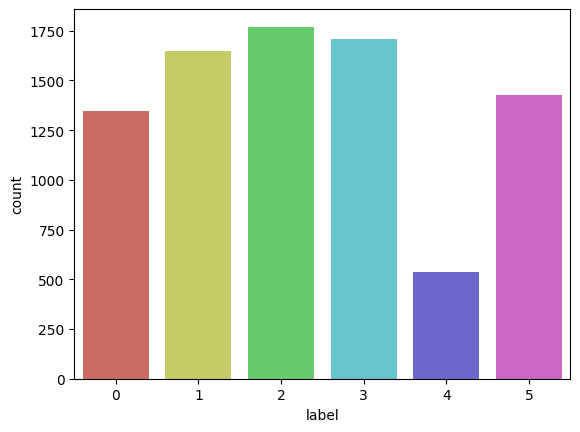

In [398]:
sns.countplot(x='label', data=df, palette='hls')

0 barely true
1 false
2 half-true
3 mostly true
4 pants on fire
5 true

In [399]:
df.groupby(['subject(s)'])['statement'].count()

,statement
subject(s),
Alcohol,1
"Alcohol,animals,children,crime",1
"Alcohol,candidates-biography,crime",1
"Alcohol,children",1
"Alcohol,children,drugs,marijuana",1
...,...
weather,5
welfare,8
women,5


In [400]:
df.columns

Index(['label', 'statement', 'subject(s)', 'speaker', 'speaker's job title',
       'state info', 'party affiliation', 'barely true counts', 'false counts',
       'half true counts', 'mostly true counts', 'pants on fire counts',
       'context'],
      dtype='object')

In [401]:
finalData = df.drop(columns=['subject(s)',  'state info', 'speaker\'s job title','party affiliation', 'barely true counts', 'mostly true counts', 'half true counts', 'false counts', 'mostly true counts', 'pants on fire counts'], axis=1)
finalData.head()


,label,statement,speaker,context
0,1,Says the Annies List political group supports ...,dwayne-bohac,a mailer
1,2,When did the decline of coal start? It started...,scott-surovell,a floor speech.
2,3,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,Denver
5,5,The Chicago Bears have had more starting quart...,robin-vos,a an online opinion-piece
7,2,I'm the only person on this stage who has work...,barack-obama,"a Democratic debate in Philadelphia, Pa."


In [402]:
finalData.to_csv('/content/drive/My Drive/finalDataLiar.csv',index=False)

In [450]:
finalData = pd.read_csv('/content/drive/My Drive/finalDataLiar.csv')
finalData

,label,statement,speaker,context
0,1,Says the Annies List political group supports ...,dwayne-bohac,a mailer
1,2,When did the decline of coal start? It started...,scott-surovell,a floor speech.
2,3,"Hillary Clinton agrees with John McCain ""by vo...",barack-obama,Denver
3,5,The Chicago Bears have had more starting quart...,robin-vos,a an online opinion-piece
4,2,I'm the only person on this stage who has work...,barack-obama,"a Democratic debate in Philadelphia, Pa."
...,...,...,...,...
25300,0,Says U.S. Rep. Charles Bass wants to privatize...,ann-mclane-kuster,"an ad, ‚ÄúJanice,‚Äù released September 6, 2012"
25301,4,"In the past two years, Democrats have spent mo...",eric-cantor,an interview on Comedy Central's Daily Show wi...
25302,2,"For the first time in more than a decade, impo...",barack-obama,a press conference
25303,3,Says Donald Trump has bankrupted his companies...,hillary-clinton,a speech on the economy


In [451]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [405]:
stopwords = stopwords.words('english')
print(stopwords)

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

In [452]:
port_sem = PorterStemmer()
def stemming(content):
    stemmed_content = re.sub('[^a-zA-Z]',' ',content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [port_sem.stem(word) for word in stemmed_content if not word in stopwords]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content
#

In [453]:
finalData['statement'] = finalData['statement'].apply(stemming)
finalData

,label,statement,speaker,context
0,1,say anni list polit group support third trimes...,dwayne-bohac,a mailer
1,2,declin coal start start natur ga took start be...,scott-surovell,a floor speech.
2,3,hillari clinton agre john mccain vote give geo...,barack-obama,Denver
3,5,chicago bear start quarterback last year total...,robin-vos,a an online opinion-piece
4,2,person stage work activ last year pass along r...,barack-obama,"a Democratic debate in Philadelphia, Pa."
...,...,...,...,...
25300,0,say u rep charl bass want privat social secur,ann-mclane-kuster,"an ad, ‚ÄúJanice,‚Äù released September 6, 2012"
25301,4,past two year democrat spent money countri spe...,eric-cantor,an interview on Comedy Central's Daily Show wi...
25302,2,first time decad import account less half oil ...,barack-obama,a press conference
25303,3,say donald trump bankrupt compani twice four time,hillary-clinton,a speech on the economy


In [454]:
finalData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25305 entries, 0 to 25304
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      25305 non-null  int64 
 1   statement  25305 non-null  object
 2   speaker    25305 non-null  object
 3   context    25305 non-null  object
dtypes: int64(1), object(3)
memory usage: 790.9+ KB


In [455]:
X = finalData.iloc[:,1].values
Y = finalData.iloc[:,0].values
X,Y

(array(['say anni list polit group support third trimest abort demand',
        'declin coal start start natur ga took start begin presid georg w bush administr',
        'hillari clinton agre john mccain vote give georg bush benefit doubt iran',
        ..., 'first time decad import account less half oil consum',
        'say donald trump bankrupt compani twice four time',
        'one claim report vindic new jersey gov chri christi bridg scandal conclus'],
       dtype=object),
 array([1, 2, 3, ..., 2, 3, 0]))

In [456]:
type(X),type(Y)

(numpy.ndarray, numpy.ndarray)

In [457]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25,  random_state=0)


In [458]:
# text into numerical value
vector = TfidfVectorizer()
tf_fit = vector.fit(X_train)
X_train = tf_fit.transform(X_train)
X_test = tf_fit.transform(X_test)

In [459]:
X_train.shape

(18978, 6684)

In [460]:
def models(X_train,Y_train):

  #Using logistic Regression
  from sklearn.linear_model import LogisticRegression
  lg = LogisticRegression(random_state=20)
  lg.fit(X_train,Y_train)

  from sklearn.tree import DecisionTreeClassifier
  ds = DecisionTreeClassifier(criterion='entropy', random_state=20)
  ds.fit(X_train,Y_train)

  from sklearn.ensemble import RandomForestClassifier
  rf = RandomForestClassifier(n_estimators=10, criterion='entropy', random_state=0)
  rf.fit(X_train,Y_train)

  print('LG training data acc: ', lg.score(X_train,Y_train))
  print('DS training data acc: ', ds.score(X_train,Y_train))
  print('RF training data acc: ', rf.score(X_train,Y_train))
  return lg,ds,rf

res = models(X_train,Y_train)
print(res)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LG training data acc:  0.7197281062282643
DS training data acc:  0.9992096111286753
RF training data acc:  0.9984192222573506
(LogisticRegression(random_state=20), DecisionTreeClassifier(criterion='entropy', random_state=20), RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0))


Confusion matrix for model  0
[[493 132 164 133   6  99]
 [ 87 714 168 130   8  92]
 [ 76 158 791 179   4 113]
 [ 78 124 161 782   4 108]
 [ 49 102  57  55 116  25]
 [ 72 125 149 188   1 584]]
Accuracy:  0.8464235624123422



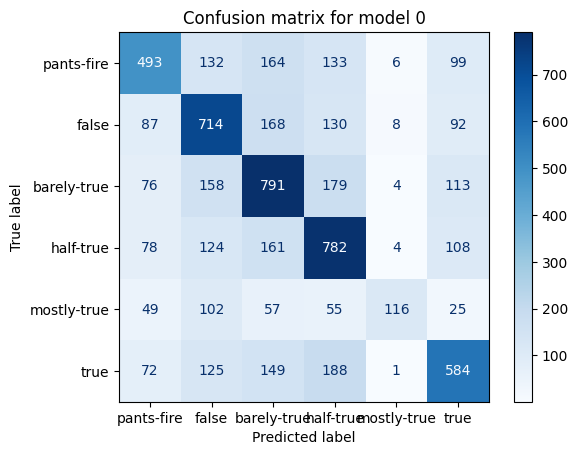

Confusion matrix for model  1
[[ 961   12   21   12    6   15]
 [   9 1133   18   18    3   18]
 [  12   10 1251   24    6   18]
 [  12   18   12 1203    3    9]
 [   0    0    3    3  395    3]
 [  12   10   15   13    0 1069]]
Accuracy:  0.9900709219858156



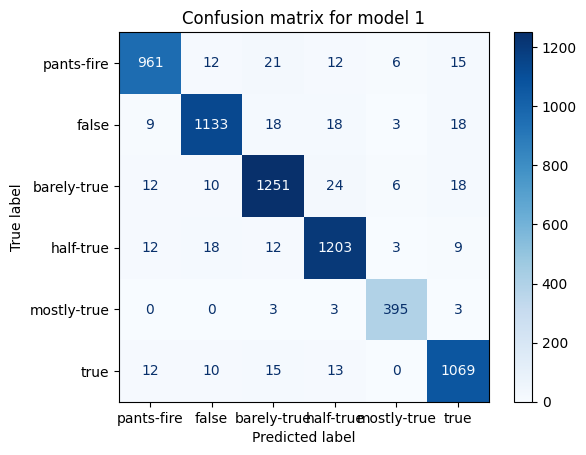

Confusion matrix for model  2
[[ 967   26   17   11    0    6]
 [   9 1152   26    6    0    6]
 [  11   29 1246   20    0   15]
 [  14   27   12 1201    3    0]
 [   0    3    3    2  393    3]
 [   5   19   16   17    0 1062]]
Accuracy:  0.9837511606313835



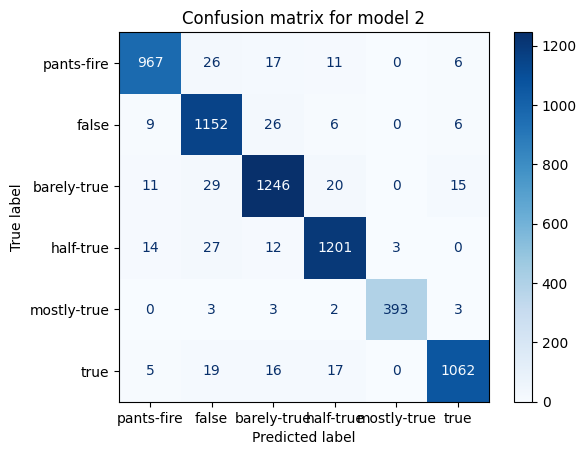

In [461]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


for i in range(len(res)):
    print('Confusion matrix for model ', i)

    # 计算混淆矩阵
    cm = confusion_matrix(Y_test, res[i].predict(X_test))
    truePositive = cm[0][0]
    trueNegative = cm[1][1]
    falsePositive = cm[1][0]
    falseNegative = cm[0][1]


    # 打印混淆矩阵和准确率
    print(cm)
    print('Accuracy: ', (truePositive + trueNegative) / (truePositive + falsePositive + falseNegative + trueNegative))
    print()

    from sklearn.metrics import ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true'])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion matrix for model {i}')
    plt.show()


In [466]:
# prediction for ds model
prediction = res[1].predict(X_test)
print('prediction values: ', prediction)
print('actual values: ', Y_test)

prediction values:  [0 5 0 ... 4 0 0]
actual values:  [0 5 0 ... 4 0 0]


In [468]:
def detectNews(news):
  input_data = {"statement": [news]}
  input = pd.DataFrame(input_data)
  input['statement'] = input['statement'].apply(stemming)
  input_statement = input['statement']

  vectorize_data = vector.transform(input_statement)
  prediction = res[1].predict(vectorize_data)
  print(prediction)
  if prediction == 0:
    print('barely-true')
  elif prediction == 1:
    print('false')
  elif prediction == 2:
    print('half-true')
  elif prediction == 3:
    print('mostly-true')
  elif prediction == 4:
    print('pants on fire')
  elif prediction == 5:
    print('true')
  else:
    print('hard to tell')

In [474]:
news = 'donald trump sucks'
detectNews(news)

[0]
barely-true
